### Importing Required Libraries

In [79]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import LinearSVC, SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from xgboost import XGBClassifier, XGBRegressor

### Loading Dataset

In [80]:
df = pd.read_json("problems_data.jsonl", lines=True)
df.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


### Text Cleaning

In [81]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

text_cols = ["title", "description", "input_description", "output_description"]
for col in text_cols:
    df[col] = df[col].fillna("").apply(clean_text)

### Combining Text Features

In [82]:
df["combined_text"] = (
    df["title"] + " " +
    df["description"] + " " +
    df["input_description"] + " " +
    df["output_description"]
)

### Adding Text Complexity Features

In [83]:
# from sklearn.preprocessing import StandardScaler
# def text_complexity_features(text):
#     words = text.split()
#     return pd.Series({
#         "word_count": len(words),
#         "avg_word_len": np.mean([len(w) for w in words]) if words else 0,
#         "digit_count": sum(c.isdigit() for c in text),
#         "symbol_count": len(re.findall(r"[+*/%=<>-]", text))
#     })
# extra_features = df["combined_text"].apply(text_complexity_features)
# scaler = StandardScaler()
# extra_features_scaled = scaler.fit_transform(extra_features)


### TF-IDF Vectorization

In [84]:
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    stop_words="english"
)

X = tfidf.fit_transform(df["combined_text"])

### Encoding Targets

In [85]:
le = LabelEncoder()
y_class = le.fit_transform(df["problem_class"])
y_score = df["problem_score"].values

### Train-Test Split

In [86]:
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X, y_class, y_score, test_size=0.2, random_state=42
)

### Trying different Classification Models

In [87]:
classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Linear SVM": LinearSVC(max_iter=5000),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=30, n_jobs=-1, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42
    )
}

### Training & Evaluating Classification Models

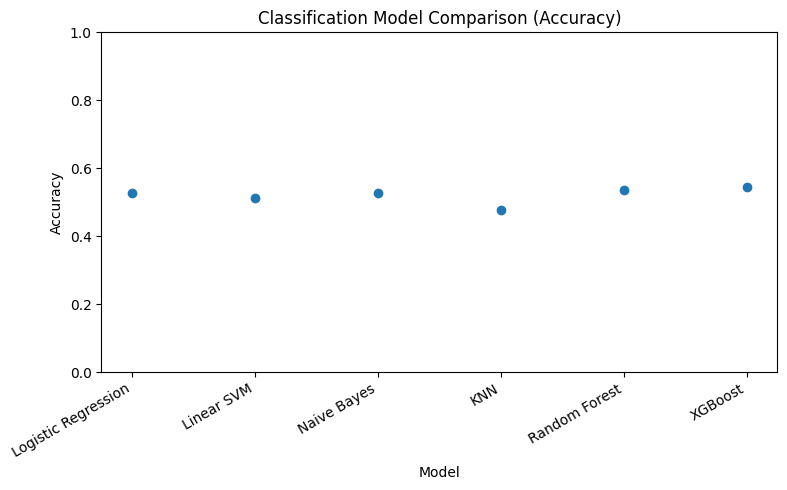

In [100]:
class_results = []

for name, model in classification_models.items():
    model.fit(X_train, y_class_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_class_test, preds)
    class_results.append((name, acc))

class_df = pd.DataFrame(class_results, columns=["Model", "Accuracy"])
class_df.sort_values(by="Accuracy", ascending=False)
plt.figure(figsize=(8, 5))

plt.scatter(class_df["Model"], class_df["Accuracy"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Classification Model Comparison (Accuracy)")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


### Selecting Best Classification Model

In [89]:
class_df = class_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
best_class_model_name = class_df.iloc[0]["Model"]
best_class_model = classification_models[best_class_model_name]

print("Best Classification Model:", best_class_model_name)

Best Classification Model: XGBoost


<Figure size 600x600 with 0 Axes>

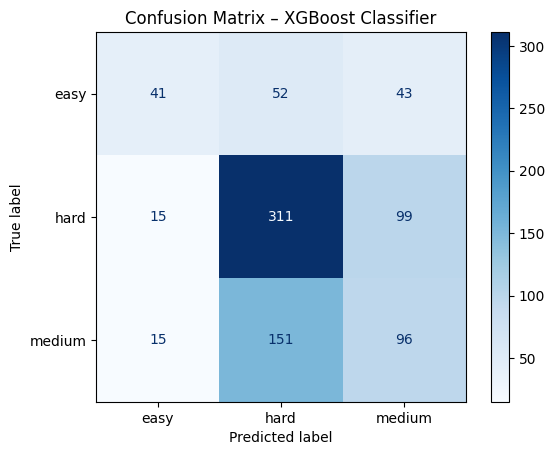

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_class_model.predict(X_test)
cm = confusion_matrix(y_class_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – XGBoost Classifier")
plt.show()


### Trying different Regression Models

In [91]:
regression_models = {
    "Ridge": Ridge(),
    "SVR": SVR(kernel="linear"),
    "Random Forest": RandomForestRegressor(
        n_estimators=300, max_depth=30, n_jobs=-1, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
}

### Training & Evaluating Regression Models

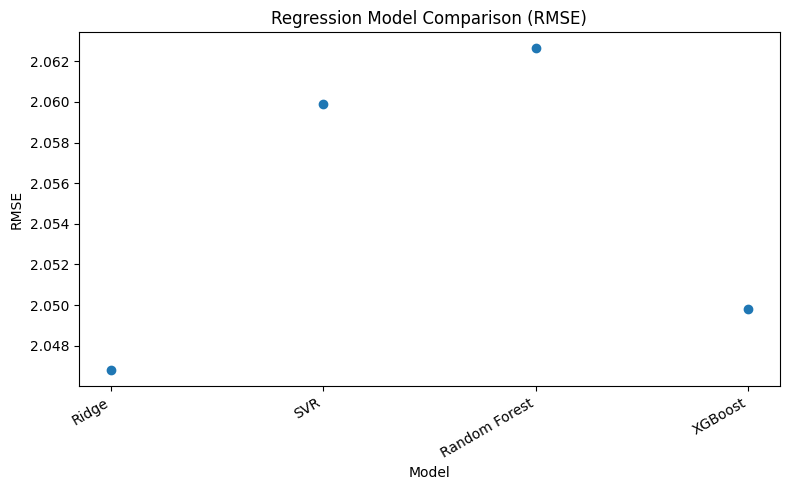

In [99]:
reg_results = []

for name, model in regression_models.items():
    model.fit(X_train, y_score_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_score_test, preds)
    rmse = np.sqrt(mean_squared_error(y_score_test, preds))
    reg_results.append((name, mae, rmse))

reg_df = pd.DataFrame(reg_results, columns=["Model", "MAE", "RMSE"])
reg_df.sort_values(by="RMSE")
plt.figure(figsize=(8, 5))

plt.scatter(reg_df["Model"], reg_df["RMSE"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.title("Regression Model Comparison (RMSE)")

plt.tight_layout()
plt.show()


### Selecting Best Regression Model

In [93]:
reg_df = reg_df.sort_values(by="RMSE")
best_reg_model_name = reg_df.iloc[0]["Model"]
best_reg_model = regression_models[best_reg_model_name]

print("Best Regression Model:", best_reg_model_name)

Best Regression Model: Ridge


### Training Best Models on Full Data

In [94]:
best_class_model.fit(X, y_class)
best_reg_model.fit(X, y_score)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


### Saving Models

In [95]:
joblib.dump(best_class_model, "final_classifier.pkl")
joblib.dump(best_reg_model, "final_regressor.pkl")
joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

### Score Adjustment Function

In [96]:
def adjust_score(score, difficulty):
    difficulty = difficulty.strip().lower()
    score = float(score)
    ranges = {
        "easy": (1.0, 3.5),
        "medium": (3.5, 7.5),
        "hard": (7.5, 10.0)
    }
    low, high = ranges[difficulty]
    return score if low <= score <= high else min(max(score, low), high)


### Prediction Function

In [97]:
def predict_problem(title, description, input_desc, output_desc):
    text = clean_text(title + " " + description + " " + input_desc + " " + output_desc)
    vec = tfidf.transform([text])

    cls = le.inverse_transform([best_class_model.predict(vec)[0]])[0]
    raw_score = float(best_reg_model.predict(vec)[0])
    score = adjust_score(raw_score, cls)
    return cls, score

### Testing Prediction

In [98]:
predict_problem(
    "Shortest Path",
    "Find shortest path using graph",
    "n nodes m edges",
    "print distance"
)

('medium', 4.276106906726305)